# Building machine-learning models to predict whether a patient will die after getting Covid-19 based on associated risk factors.
## author: Dr. Reynier Cruz Torres

## Data source and details:

https://www.kaggle.com/datasets/meirnizri/covid19-dataset

The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data and doing exploratory analysis 

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


#### Classification final >= 4 means the patient didn't have Covid. I want to start with patients known to have Covid.

In [4]:
df = df[df['CLASIFFICATION_FINAL']<4]

#### Patient type means whether the patient was hospitalized or not. This is another decision I want my ML model to make. I will drop this feature. Similarly, I will drop the ICU, USMR, and MEDICAL_UNIT features.

In [5]:
df = df.drop(['PATIENT_TYPE','ICU','USMER','MEDICAL_UNIT'],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391979 entries, 0 to 1047937
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   SEX                   391979 non-null  int64 
 1   DATE_DIED             391979 non-null  object
 2   INTUBED               391979 non-null  int64 
 3   PNEUMONIA             391979 non-null  int64 
 4   AGE                   391979 non-null  int64 
 5   PREGNANT              391979 non-null  int64 
 6   DIABETES              391979 non-null  int64 
 7   COPD                  391979 non-null  int64 
 8   ASTHMA                391979 non-null  int64 
 9   INMSUPR               391979 non-null  int64 
 10  HIPERTENSION          391979 non-null  int64 
 11  OTHER_DISEASE         391979 non-null  int64 
 12  CARDIOVASCULAR        391979 non-null  int64 
 13  OBESITY               391979 non-null  int64 
 14  RENAL_CHRONIC         391979 non-null  int64 
 15  TOBACCO         

### While it looks like there is nothing missing, the dataset description indicates that missing values are just assigned the numbers 97 or 98. We need to deal with this.

## Feature engineering

In [7]:
def change_vals(val):
    if val==1: return 1
    elif val==2: return 0
    else: return np.NaN
    
def is_male(val):
    if val == 1: return 0
    elif val == 2: return 1
    else: return np.NaN
    
def pregnant_male(pregnant,is_male):
    if is_male: return 0
    else: return pregnant
    
def attach_labels(date):
    if date == '9999-99-99': return 1 # This means the patient didn't die
    else: return 0

In [8]:
cols_to_change = ['COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR',
                  'OBESITY','RENAL_CHRONIC','TOBACCO','DIABETES','INTUBED',
                  'PNEUMONIA','PREGNANT']

for col in cols_to_change:
    df[col] = df[col].apply(change_vals)
    
df['is_male'] = df['SEX'].apply(is_male)
df = df.drop('SEX',axis=1)

df['PREGNANT'] = df.apply(lambda x:pregnant_male(x['PREGNANT'],x['is_male']),axis=1)

df['survived'] = df['DATE_DIED'].apply(attach_labels)
df = df.drop('DATE_DIED',axis=1)

In [9]:
df.head()

,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,is_male,survived
0,NaN,1.0,65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0,0
2,1.0,0.0,55,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0
4,NaN,0.0,68,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1,0
5,0.0,1.0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1
6,NaN,0.0,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1


## Missing data

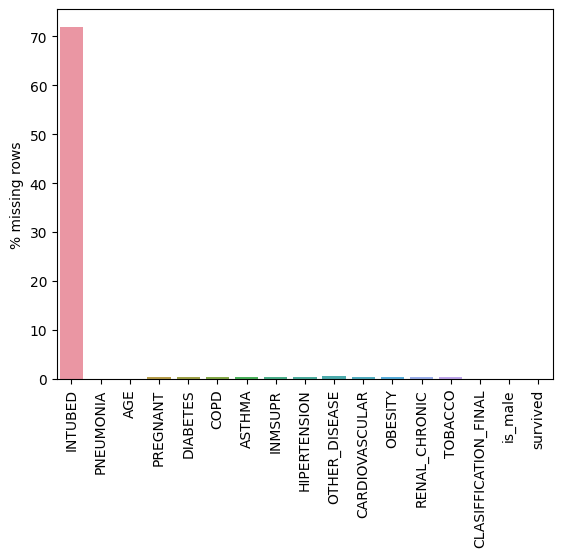

In [10]:
missing_fraction = pd.Series(df.isnull().sum()/len(df)*100)
sns.barplot(x=missing_fraction.index,y=missing_fraction.values)
plt.xticks(rotation=90)
plt.ylabel('% missing rows')
plt.show()

#### Over 70% of 'INTUBED' rows are missing. I will drop this feature. In any case, I am not very interested in that feature, since I want to predict whether a patient is at high risk before they get sent to the ICU.

In [11]:
df = df.drop('INTUBED',axis=1)

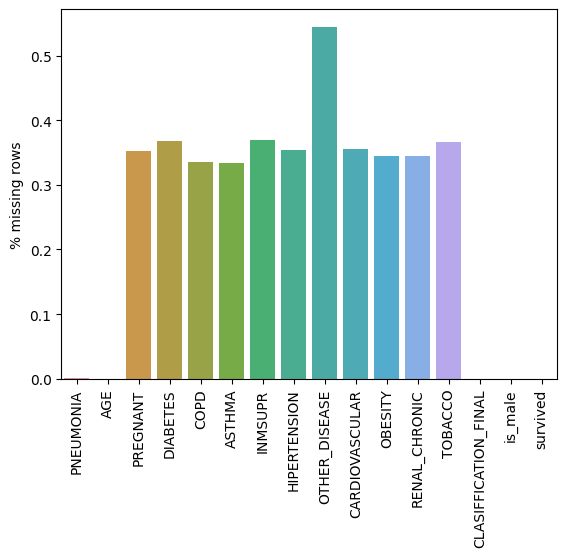

In [12]:
missing_fraction = pd.Series(df.isnull().sum()/len(df)*100)
sns.barplot(x=missing_fraction.index,y=missing_fraction.values)
plt.xticks(rotation=90)
plt.ylabel('% missing rows')
plt.show()

#### The remaining missing values are < 0.6% of the rows. I will drop these rows.

In [13]:
df = df.dropna()
len(df)

387596

## Studying correlations between these variables

<AxesSubplot: >

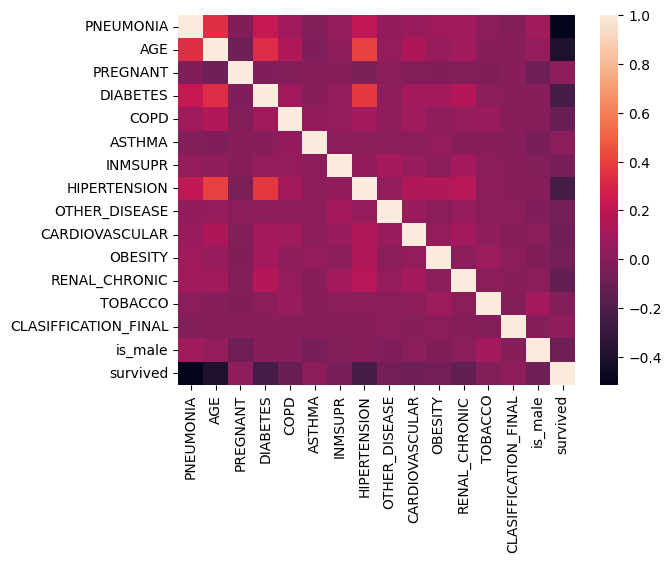

In [14]:
sns.heatmap(df.corr())

In [15]:
correlations = df.corr()['survived'].sort_values()[:-1]
correlations

PNEUMONIA              -0.513038
AGE                    -0.397862
DIABETES               -0.237644
HIPERTENSION           -0.235252
RENAL_CHRONIC          -0.129588
COPD                   -0.100898
is_male                -0.091704
CARDIOVASCULAR         -0.085348
OBESITY                -0.061055
OTHER_DISEASE          -0.060896
INMSUPR                -0.050597
TOBACCO                -0.011539
ASTHMA                  0.016209
CLASIFFICATION_FINAL    0.025766
PREGNANT                0.028186
Name: survived, dtype: float64

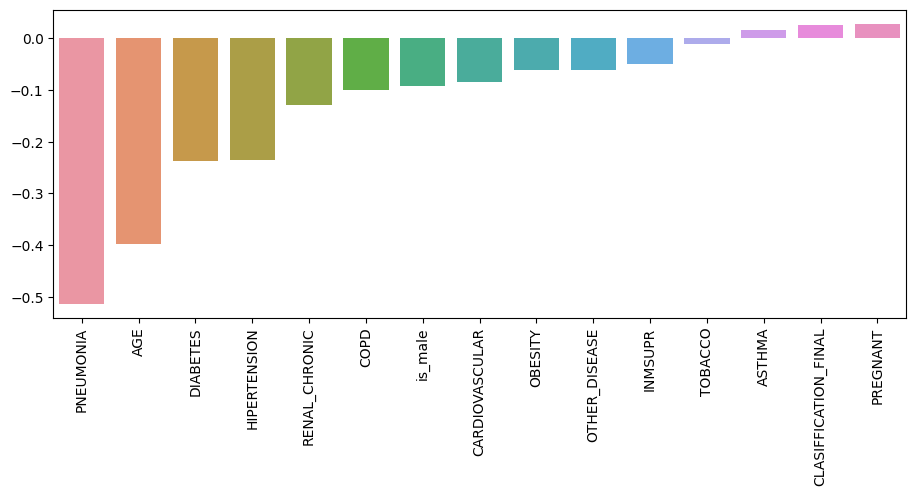

In [16]:
plt.figure(figsize=(11,4))
sns.barplot(x=correlations.index,y=correlations.values)
plt.xticks(rotation = 90)
plt.show()

#### Whether the patient had pneumonia or not (followed by age, then diabetes and hypertension) is the most (anti)correlated variable with the outcome of the patient. It is interesting to see that whether the patient suffered from asthma, indicates tobacco use, or is inmunosuppressed is not very correlated with the outcome.

<AxesSubplot: xlabel='survived', ylabel='AGE'>

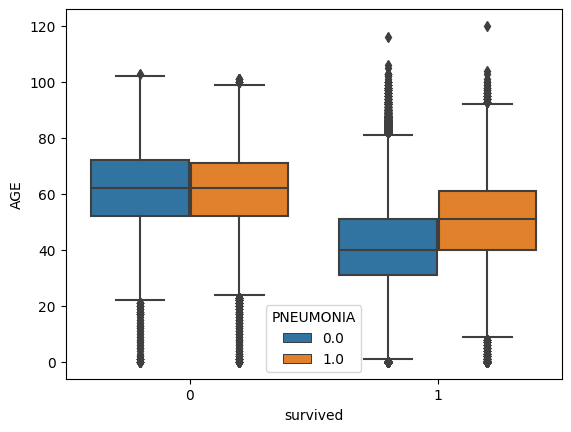

In [17]:
sns.boxplot(data=df,x='survived',y='AGE',hue='PNEUMONIA')

<AxesSubplot: xlabel='AGE', ylabel='Count'>

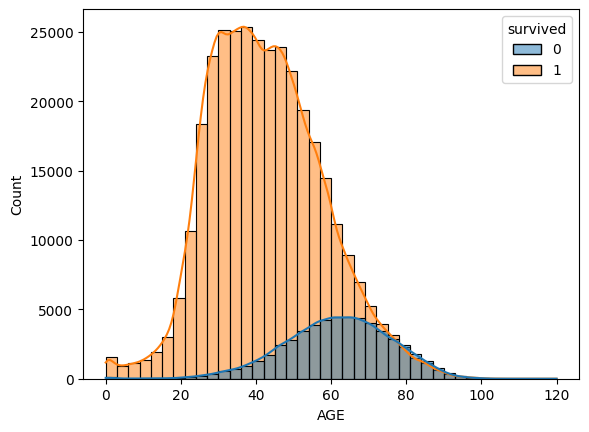

In [18]:
sns.histplot(data=df,x='AGE',hue='survived',bins=40,kde=True)

<AxesSubplot: xlabel='survived', ylabel='AGE'>

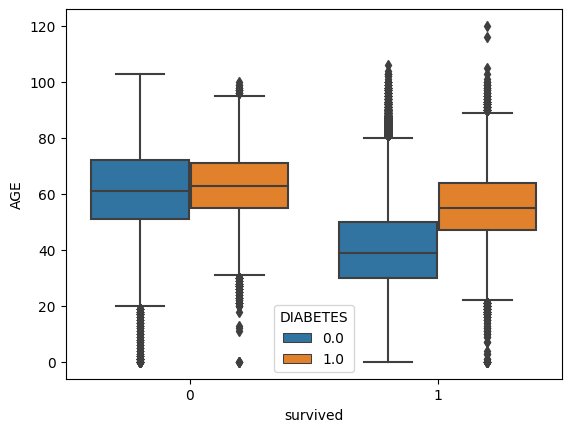

In [19]:
sns.boxplot(data=df,x='survived',y='AGE',hue='DIABETES')

#### Let's see whether our labels are balanced.

<AxesSubplot: xlabel='survived', ylabel='count'>

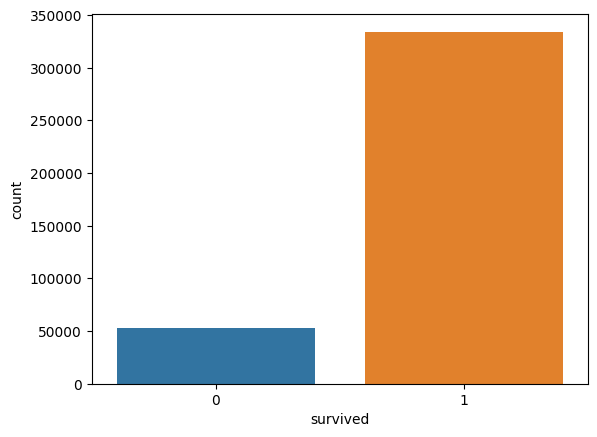

In [20]:
sns.countplot(data=df[df['CLASIFFICATION_FINAL']<4],x='survived')

### Need to do something later on about these imbalanced classes, because otherwise the models won't perform well

## Undersampling to balance classes

In [21]:
X = df.drop('survived',axis=1)
y = df['survived']

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled,y_resampled = rus.fit_resample(X,y)

## Modeling
#### Split data into train and test sets

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

#### Scaling the data

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#### Create and train model

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import time

def create_train_evaluate(model,X_train,y_train,X_test,y_test,param_grid,label='model'):
    
    t0 = time.time()
    
    # Train model
    gs = GridSearchCV(model,param_grid=param_grid,cv=5)
    gs.fit(X_train,y_train)
    
    t = (time.time()-t0)/60.
    
    # Evaluate model
    preds = gs.predict(scaled_X_test)

    print(classification_report(y_test,preds))
    print('Best estimator',gs.best_estimator_)
    
    preds = gs.predict(X_test)
    cm = confusion_matrix(y_test,preds,normalize='all')
    #fpr, tpr, thresh = roc_curve(y_test,preds)
    
    fig,ax = plt.subplots(ncols=2,figsize=(9,3))
    ConfusionMatrixDisplay(cm,display_labels=['died','survived']).plot(ax=ax[0])
    roc = RocCurveDisplay.from_estimator(gs,X_test,y_test,ax=ax[1],name=label)
    ax[1].plot([0,1],[0,1],color='black',ls='--')
    ax[1].set_xlim(0,1)
    ax[1].set_ylim(0,1)
    plt.tight_layout()
    
    print('Training took',np.round(t,2),'min')
        
    return gs, roc

### Random forest

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     16034
           1       0.85      0.81      0.83     15960

    accuracy                           0.83     31994
   macro avg       0.83      0.83      0.83     31994
weighted avg       0.83      0.83      0.83     31994

Best estimator RandomForestClassifier(n_estimators=80)
Training took 0.55 min


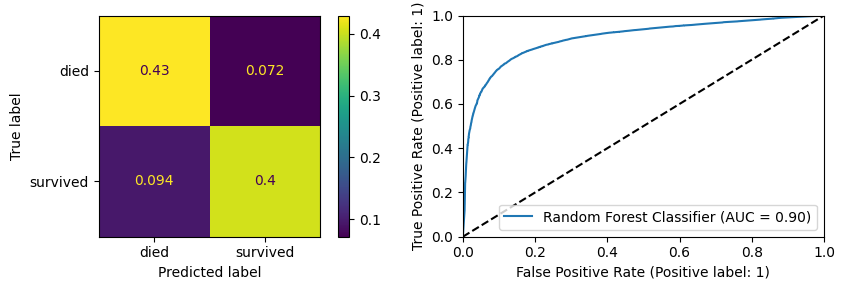

In [25]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators':[80,83,85,86]}
rf, rf_roc = create_train_evaluate(RandomForestClassifier(),scaled_X_train,y_train,
                                   scaled_X_test,y_test,param_grid,'Random Forest Classifier')

### Boosted Trees

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     16034
           1       0.87      0.81      0.84     15960

    accuracy                           0.85     31994
   macro avg       0.85      0.85      0.85     31994
weighted avg       0.85      0.85      0.85     31994

Best estimator GradientBoostingClassifier(n_estimators=115)
Training took 1.72 min


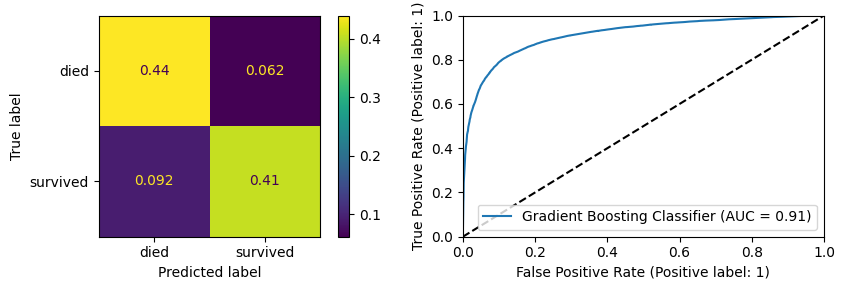

In [26]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
param_grid = {'n_estimators':[112,115,120],'max_depth':[2,3,4]}
bt, bt_roc = create_train_evaluate(GradientBoostingClassifier(),scaled_X_train,y_train,
                                   scaled_X_test,y_test,param_grid,'Gradient Boosting Classifier')

### Logistic regression

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     16034
           1       0.84      0.84      0.84     15960

    accuracy                           0.84     31994
   macro avg       0.84      0.84      0.84     31994
weighted avg       0.84      0.84      0.84     31994

Best estimator LogisticRegression(C=0.5)
Training took 0.02 min


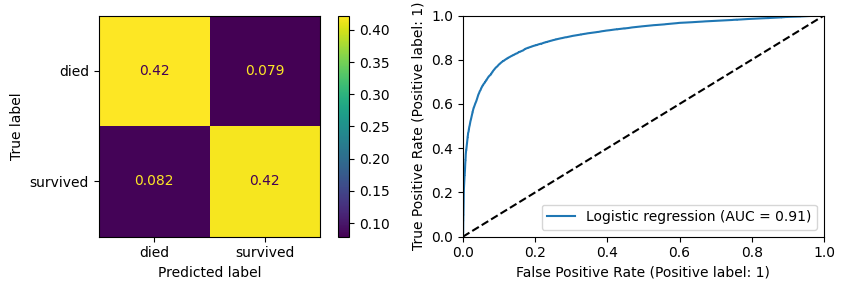

In [27]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C':[1.0,0.5,0.01,0.2],'max_iter':[100,200,300]}
lr, lr_roc = create_train_evaluate(LogisticRegression(),scaled_X_train,y_train,
                                   scaled_X_test,y_test,param_grid,'Logistic regression')

### SVM Classifier

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     16034
           1       0.85      0.82      0.84     15960

    accuracy                           0.84     31994
   macro avg       0.84      0.84      0.84     31994
weighted avg       0.84      0.84      0.84     31994

Best estimator SVC()
Training took 6.23 min


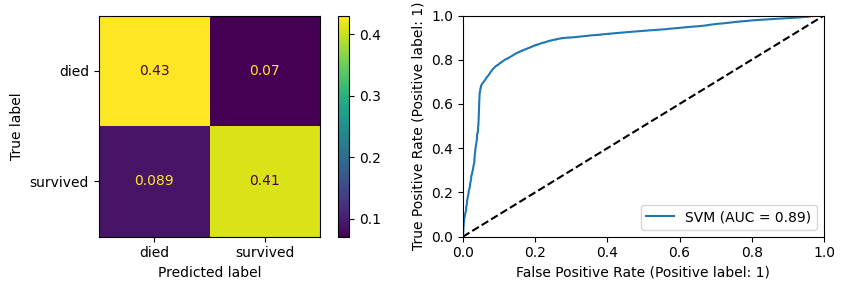

In [28]:
from sklearn.svm import SVC
param_grid = {'C':[1.0],'degree':[3]}
svm, svm_roc = create_train_evaluate(SVC(),scaled_X_train,y_train,scaled_X_test,y_test,param_grid,'SVM')

### SGDClassifier

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     16034
           1       0.83      0.84      0.83     15960

    accuracy                           0.83     31994
   macro avg       0.83      0.83      0.83     31994
weighted avg       0.83      0.83      0.83     31994

Best estimator SGDClassifier()
Training took 0.02 min


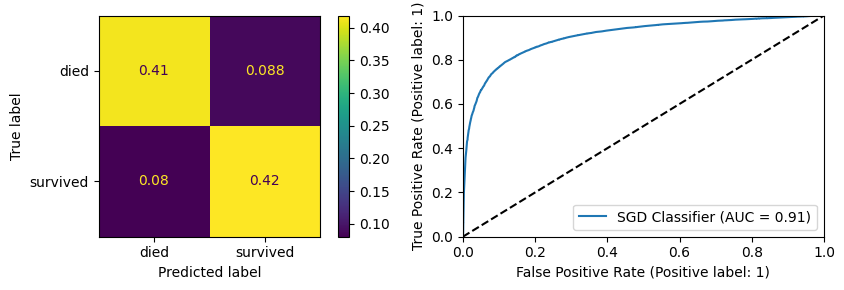

In [29]:
from sklearn.linear_model import SGDClassifier
param_grid = {'epsilon':[0.1,0.01,0.5]}
sgd, sgd_roc = create_train_evaluate(SGDClassifier(),scaled_X_train,y_train,
                                     scaled_X_test,y_test,param_grid,'SGD Classifier')

### Feed-forward NN

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [31]:
model = Sequential()
model.add(Dense(X.shape[1],'relu'))
model.add(Dropout(0.5))
model.add(Dense(6,'relu'))
model.add(Dropout(0.5))
model.add(Dense(1,'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=3)

In [33]:
model.fit(x=scaled_X_train,y=y_train,validation_data=(scaled_X_test,y_test),epochs=100,callbacks=[early_stop])

Epoch 1/100


2022-12-15 13:02:11.362559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2333/2333 [==============================] - 2s 540us/step - loss: 0.5382 - val_loss: 0.3915
Epoch 2/100
2333/2333 [==============================] - 1s 484us/step - loss: 0.4610 - val_loss: 0.3870
Epoch 3/100
2333/2333 [==============================] - 1s 487us/step - loss: 0.4539 - val_loss: 0.3833
Epoch 4/100
2333/2333 [==============================] - 1s 486us/step - loss: 0.4488 - val_loss: 0.3807
Epoch 5/100
2333/2333 [==============================] - 1s 484us/step - loss: 0.4475 - val_loss: 0.3817
Epoch 6/100
2333/2333 [==============================] - 1s 493us/step - loss: 0.4439 - val_loss: 0.3854
Epoch 7/100
2333/2333 [==============================] - 1s 502us/step - loss: 0.4454 - val_loss: 0.3808


Text(0, 0.5, 'loss')

<Figure size 640x480 with 0 Axes>

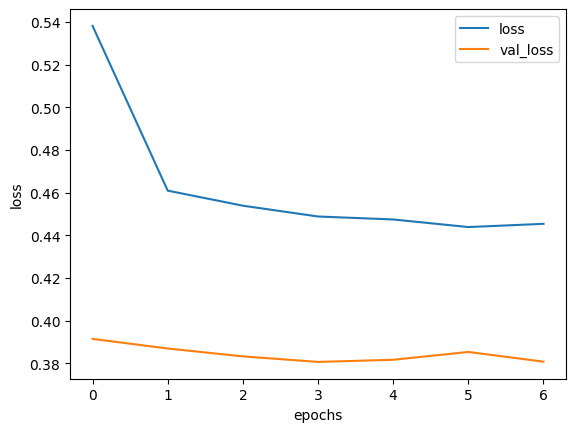

In [34]:
plt.figure()
history = pd.DataFrame(model.history.history)
history.plot()
plt.xlabel('epochs')
plt.ylabel('loss')

1000/1000 [==============================] - 0s 232us/step


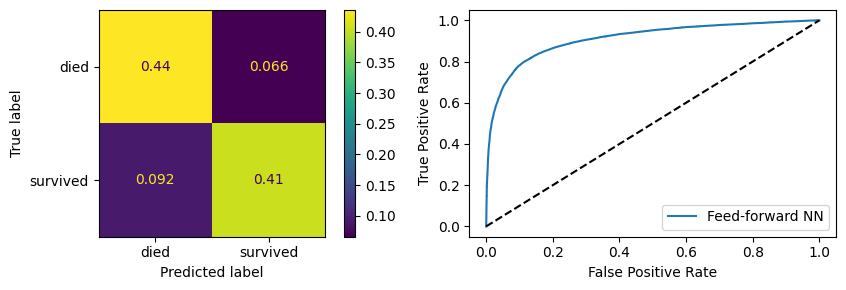

In [35]:
preds_proba = model.predict(scaled_X_test)
preds = (preds_proba>0.5).astype(int)

#preds =model.predict(scaled_X_test).ravel()
cm = confusion_matrix(y_test,preds,normalize='all')
fpr, tpr, thresh = roc_curve(y_test,preds_proba)

fig,ax = plt.subplots(ncols=2,figsize=(9,3))
ConfusionMatrixDisplay(cm,display_labels=['died','survived']).plot(ax=ax[0])
nn_roc = RocCurveDisplay(fpr=fpr,tpr=tpr,estimator_name='Feed-forward NN')
nn_roc.plot(ax=ax[1])
ax[1].plot([0,1],[0,1],color='black',ls='--')
plt.tight_layout()

(0.0, 1.0)

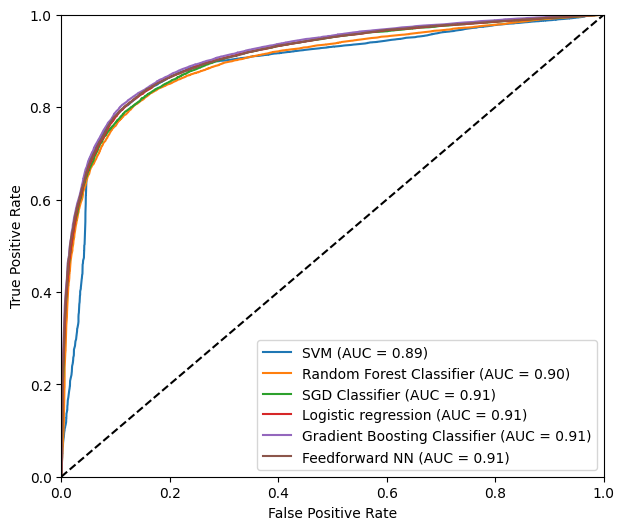

In [37]:
from sklearn.metrics import auc

fig,ax = plt.subplots(figsize=(7,6))

nn_roc.estimator_name = 'Feedforward NN (AUC = {})'.format(np.round(auc(fpr,tpr),2))

svm_roc.plot(ax=ax)
rf_roc.plot(ax=ax)
sgd_roc.plot(ax=ax)
lr_roc.plot(ax=ax)
bt_roc.plot(ax=ax)
nn_roc.plot(ax=ax)
ax.plot([0,1],[0,1],color='black',ls='--')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

#### The fact that all models lead to very similar performance seems to indicate that this is as good as we will do with this dataset. Maybe we can try a different sampling to deal with the inbalanced classes or maybe we can try some other models, hyperparameter tweaks, etc.